# Interactive Laborforce Participation Rate Map

## Goals:
### 1. Demonstrate how to use cyberGIS to map US Census Bureau data

*   Provide informative links, data, and template style code for you to refer to.

### 2. Identify a meaningful metric you can model and visualize

*   Laborforce participation can be derived from a simple model. 
*   This is sometimes an overlooked metric that can be critical to reenrolling discouraged workers into the workforce. Addressing this topic is central in political policy debates. The importance of laborforce participation has been made especially prominent by standing labor shortages since the global Covid-19 pandemic began. 

### 3. Visualize the data and export webmaps
*   This python notebook uses data provided by the US Census Bureau to make interactive maps using Python. This notebook can be a resource for exploratory work with US Census data, both in its unmodified state and after doing some modifications. This is very useful if you are planning to do advanced modelling, or just want to visually display a table. 



This notebook was written by Ben Liebersohn in 2021 for the Cyber GIS Center RIF meeting, 10/25/2021 

The function to set up Bokeh is by Dr. Ziqi Li. It allows us to use Bokeh for mapping purposes.

### Some useful and practical python skills/topics

- [Using `censusdata` library to pull ACS data](#census)
- [Geocoding using `geopandas`](#geocoding)
- [Spatial join using `geopandas` (e.g. point-in-polygon)](#sj)
- [Interactive map with `bokeh`](#bokeh)



Further resources:

`censusdata`: https://jtleider.github.io/censusdata/

`geopandas` geocoding: https://automating-gis-processes.github.io/CSC18/lessons/L3/geocoding.html

`geopandas` spatial join: https://geopandas.org/mergingdata.html

`bokeh` example: https://docs.bokeh.org/en/latest/docs/gallery/texas.html

Download shapefile for the US counties from TIGER/Shapefile website, or for this one (cb_2018_us_county_20m.zip), download it here: https://drive.google.com/file/d/1Mv6f4SeVEk75-K1fRRheFXEAh94U_y0f/view?usp=sharing

In [1]:
!unzip cb_2018_us_county_20m.zip
# This extracts our compressed folder. If it "cannot find or open" then you need to upload the zip file
# Notice all the output, this is useful for understanding what is happening 

Archive:  cb_2018_us_county_20m.zip
   creating: cb_2018_us_county_20m/
  inflating: __MACOSX/._cb_2018_us_county_20m  
  inflating: cb_2018_us_county_20m/cb_2018_us_county_20m.dbf  
  inflating: __MACOSX/cb_2018_us_county_20m/._cb_2018_us_county_20m.dbf  
  inflating: cb_2018_us_county_20m/cb_2018_us_county_20m.shp.ea.iso.xml  
  inflating: __MACOSX/cb_2018_us_county_20m/._cb_2018_us_county_20m.shp.ea.iso.xml  
  inflating: cb_2018_us_county_20m/cb_2018_us_county_20m.shx  
  inflating: __MACOSX/cb_2018_us_county_20m/._cb_2018_us_county_20m.shx  
  inflating: cb_2018_us_county_20m/cb_2018_us_county_20m.shp  
  inflating: __MACOSX/cb_2018_us_county_20m/._cb_2018_us_county_20m.shp  
  inflating: cb_2018_us_county_20m/cb_2018_us_county_20m.cpg  
  inflating: __MACOSX/cb_2018_us_county_20m/._cb_2018_us_county_20m.cpg  
  inflating: cb_2018_us_county_20m/cb_2018_us_county_20m.shp.iso.xml  
  inflating: __MACOSX/cb_2018_us_county_20m/._cb_2018_us_county_20m.shp.iso.xml  
  inflating: cb_2018

In [2]:
!apt-get install -y python-rtree; #Semicolon at the end suppresses the output when installing the rtree library

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  javascript-common libjs-jquery libjs-underscore libspatialindex-c4v5
  libspatialindex-dev libspatialindex4v5 python-pkg-resources
Suggested packages:
  apache2 | lighttpd | httpd python-setuptools
The following NEW packages will be installed:
  javascript-common libjs-jquery libjs-underscore libspatialindex-c4v5
  libspatialindex-dev libspatialindex4v5 python-pkg-resources python-rtree
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 959 kB of archives.
After this operation, 5,146 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 javascript-common all 11 [6,066 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libjs-jquery all 3.2.1-1 [152 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libjs-underscore all 1.8.3~dfsg-1ubuntu0.1 [6

In [3]:
!pip install pygeos #We install some libraries with the tool called "pip"
!pip install geopandas; #semicolon suppressed output
# If you want to learn more about these libraries, Google search "Pygeos" or "geopandas"

     |████████████████████████████████| 1.8 MB 7.3 MB/s 
     |████████████████████████████████| 1.0 MB 9.6 MB/s 
     |████████████████████████████████| 6.3 MB 47.1 MB/s 
     |████████████████████████████████| 15.4 MB 76 kB/s 


In [4]:
import pygeos # Now that we installed pygeos, we still need to import them
import pandas as pd # by using the shorter names we save some time later on
import numpy as np # instead of calling it numpy we call it np
import geopandas as gpd # even though we are calling it gpd it is still widely known as "geopandas"

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


<a id='census'></a>
### Census API


In [5]:
!pip install censusdata # We install and import the censusdata library
import censusdata # This library loads census data for us, so we don't need to go to the US Census Bureau website

     |████████████████████████████████| 26.6 MB 54.9 MB/s 
  Created wheel for censusdata: filename=CensusData-1.15-py3-none-any.whl size=28205534 sha256=ab006abf0623076468d91aceaafd0f69630c321214eb0c60bdfe48c2dcf2208a
  Stored in directory: /root/.cache/pip/wheels/17/11/8c/933901298f486bd414f2ab1a62a114085f7d7a19dcbda2dd08
Successfully built censusdata


In [6]:
censusdata.printtable(censusdata.censustable('acs5', 2018, 'B28007')) # 2018 ACS 5 YEAR: LABOR FORCE STATUS BY PRESENCE OF A COMPUTER AND TYPES OF INTERNET SUBSCRIPTION IN HOUSEHOLD

Variable     | Table                          | Label                                                    | Type 
-------------------------------------------------------------------------------------------------------------------
B28007_001E  | LABOR FORCE STATUS BY PRESENCE | !! Estimate Total                                        | int  
B28007_002E  | LABOR FORCE STATUS BY PRESENCE | !! !! Estimate Total In the civilian labor force         | int  
B28007_003E  | LABOR FORCE STATUS BY PRESENCE | !! !! !! Estimate Total In the civilian labor force Empl | int  
B28007_004E  | LABOR FORCE STATUS BY PRESENCE | !! !! !! !! Estimate Total In the civilian labor force E | int  
B28007_005E  | LABOR FORCE STATUS BY PRESENCE | !! !! !! !! !! Estimate Total In the civilian labor forc | int  
B28007_006E  | LABOR FORCE STATUS BY PRESENCE | !! !! !! !! !! Estimate Total In the civilian labor forc | int  
B28007_007E  | LABOR FORCE STATUS BY PRESENCE | !! !! !! !! !! Estimate Total In the civilian

In [160]:
labor = censusdata.download('acs5', 2018,
           censusdata.censusgeo([('state', '17'),  # STATE is Illinois
                                 ('county', '*')]), # All Counties in Illinois
                                 ['B28007_001E','B28007_002E','B28007_006E','B28007_012E','B28007_018E'])

labor.columns = ['total','total_in_laborforce','employed_w_broadband','unemployed_w_broadband','not_laborforce_w_broadband']

# B28007_006E == EMPLOYED WITH BROADBAND
# B28007_012E == UNEMPLOYED WITH BROADBAND
# B28007_018E == NOT IN LABOR FORCE WITH BROADBAND

In [161]:
labor

,total,total_in_laborforce,employed_w_broadband,unemployed_w_broadband,not_laborforce_w_broadband
"Sangamon County, Illinois: Summary level: 050, state:17> county:167",154099,101125,83313,4640,38642
"Randolph County, Illinois: Summary level: 050, state:17> county:157",22710,13616,10998,504,6194
"Ogle County, Illinois: Summary level: 050, state:17> county:141",40539,26412,22118,1369,10106
"Morgan County, Illinois: Summary level: 050, state:17> county:137",25182,15997,13080,863,6125
"White County, Illinois: Summary level: 050, state:17> county:193",10879,6426,5047,433,2905
...,...,...,...,...,...
"De Witt County, Illinois: Summary level: 050, state:17> county:039",12731,8576,7053,387,2895
"Lee County, Illinois: Summary level: 050, state:17> county:103",25223,16053,13706,573,6549
"Macoupin County, Illinois: Summary level: 050, state:17> county:117",36210,21949,18088,1344,10411
"Richland County, Illinois: Summary level: 050, state:17> county:159",12375,7652,6240,353,3214


In [162]:
# Declaring a new list as a column: pct_in_laborforce = 100*(total_in_laborforce/total)
# Example: IF total pop = 20, total_in_laborforce = 10, THEN pct_in_laborforce = 50
pct_in_laborforce = 100*(labor.total_in_laborforce.divide(labor.total))
labor['pct_in_laborforce'] = pct_in_laborforce

In [163]:
censusdata.export.exportcsv("labor.csv", labor)
labor = pd.read_csv("labor.csv")

In [164]:
labor.head()

,state,county,NAME,total,total_in_laborforce,employed_w_broadband,unemployed_w_broadband,not_laborforce_w_broadband,pct_in_laborforce
0,17,167,"Sangamon County, Illinois",154099,101125,83313,4640,38642,65.623398
1,17,157,"Randolph County, Illinois",22710,13616,10998,504,6194,59.955967
2,17,141,"Ogle County, Illinois",40539,26412,22118,1369,10106,65.152076
3,17,137,"Morgan County, Illinois",25182,15997,13080,863,6125,63.525534
4,17,193,"White County, Illinois",10879,6426,5047,433,2905,59.067929


In [165]:
labor["GEOID"]= (labor['state'].astype(str).str.zfill(2) + labor['county'].astype(str).str.zfill(3)).astype(int)

In [166]:
# Read in shapefile, and convert TRACTCE to type INT
counties = gpd.read_file("/content/cb_2018_us_county_20m/cb_2018_us_county_20m.shp") 
counties["GEOID_int"] = counties.GEOID.astype(int)
# Drop non-IL data from the map
#counties.drop('STATEFP'=='17')

In [167]:
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,GEOID_int
0,37,017,01026336,0500000US37017,37017,Bladen,06,2265887723,33010866,"POLYGON ((-78.90200 34.83527, -78.79960 34.850...",37017
1,37,167,01025844,0500000US37167,37167,Stanly,06,1023370459,25242751,"POLYGON ((-80.49737 35.20210, -80.29542 35.502...",37167
2,39,153,01074088,0500000US39153,39153,Summit,06,1069181981,18958267,"POLYGON ((-81.68699 41.13596, -81.68495 41.277...",39153
3,42,113,01213687,0500000US42113,42113,Sullivan,06,1165338428,6617028,"POLYGON ((-76.81373 41.59003, -76.22014 41.541...",42113
4,48,459,01384015,0500000US48459,48459,Upshur,06,1509910100,24878888,"POLYGON ((-95.15274 32.66095, -95.15211 32.902...",48459


In [168]:
counties["GEOID_int"] = counties.GEOID.astype(int)

In [169]:
# Join US Counties shapefile with the workforce data
labor_county_merged = gpd.GeoDataFrame(pd.merge(labor,counties,how="left",left_on="GEOID",right_on='GEOID_int'))

#labor_county_map = gpd.GeoDataFrame(pd.merge(labor,counties,how="left",left_on="county",right_on="COUNTYFP"))

In [170]:
labor_county_merged

,state,county,NAME_x,total,total_in_laborforce,employed_w_broadband,unemployed_w_broadband,not_laborforce_w_broadband,pct_in_laborforce,GEOID_x,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID_y,NAME_y,LSAD,ALAND,AWATER,geometry,GEOID_int
0,17,167,"Sangamon County, Illinois",154099,101125,83313,4640,38642,65.623398,17167,17,167,01785010,0500000US17167,17167,Sangamon,06,2248877362,22577724,"POLYGON ((-89.99451 39.90192, -89.76924 39.902...",17167
1,17,157,"Randolph County, Illinois",22710,13616,10998,504,6194,59.955967,17157,17,157,01784967,0500000US17157,17157,Randolph,06,1490060417,56152454,"POLYGON ((-90.20389 38.08737, -90.03587 38.135...",17157
2,17,141,"Ogle County, Illinois",40539,26412,22118,1369,10106,65.152076,17141,17,141,01784894,0500000US17141,17141,Ogle,06,1964742119,11425028,"POLYGON ((-89.68849 42.19911, -89.39619 42.201...",17141
3,17,137,"Morgan County, Illinois",25182,15997,13080,863,6125,63.525534,17137,17,137,00424270,0500000US17137,17137,Morgan,06,1473180230,9059958,"POLYGON ((-90.57175 39.83933, -90.58365 39.876...",17137
4,17,193,"White County, Illinois",10879,6426,5047,433,2905,59.067929,17193,17,193,00424297,0500000US17193,17193,White,06,1281491812,18346746,"POLYGON ((-88.37037 38.25532, -88.15090 38.256...",17193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,17,39,"De Witt County, Illinois",12731,8576,7053,387,2895,67.363129,17039,17,039,00426598,0500000US17039,17039,De Witt,06,1029654716,19515948,"POLYGON ((-89.14876 40.28204, -88.91954 40.282...",17039
98,17,103,"Lee County, Illinois",25223,16053,13706,573,6549,63.644293,17103,17,103,00424253,0500000US17103,17103,Lee,06,1877336056,10634483,"POLYGON ((-89.62933 41.90162, -89.42673 41.908...",17103
99,17,117,"Macoupin County, Illinois",36210,21949,18088,1344,10411,60.615852,17117,17,117,00424257,0500000US17117,17117,Macoupin,06,2234952036,12252472,"POLYGON ((-90.15375 39.52031, -89.92604 39.522...",17117
100,17,159,"Richland County, Illinois",12375,7652,6240,353,3214,61.834343,17159,17,159,00424281,0500000US17159,17159,Richland,06,932537547,4874777,"POLYGON ((-88.25778 38.73114, -88.25858 38.847...",17159


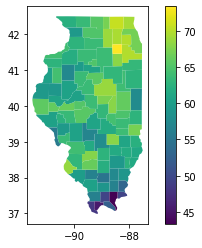

In [171]:
labor_county_merged.plot(column="pct_in_laborforce",legend=True)

In [172]:
#exporting to shapefile for more analysis with ArcGIS Pro
labor_county_map.to_file("labor_county_map.shp")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  


<a id='bokeh'></a>
### Interactive mapping


In [173]:
#We use an awesome package called bokeh (I love this package!)

from bokeh.io import output_file, show,output_notebook
from bokeh.models import ColumnDataSource,ColorBar,HoverTool
from bokeh.transform import linear_cmap
from bokeh.plotting import figure
from bokeh.palettes import Spectral6 #https://docs.bokeh.org/en/latest/docs/reference/palettes.html

In [174]:
#To make your map be outputted inline
output_notebook()

In [175]:
#Don't change this!!!
#Just copy this whole cell.
#This is a helper function for converting a GeoDataFrame to the format that bokeh can recognize.

def gpd_bokeh(df):
    """Convert geometries from geopandas to bokeh format"""
    nan = float('nan')
    lons = []
    lats = []
    for i,shape in enumerate(df.geometry.values):
        if shape.geom_type == 'MultiPolygon':
            gx = []
            gy = []
            ng = len(shape.geoms) - 1
            for j,member in enumerate(shape.geoms):
                xy = np.array(list(member.exterior.coords))
                xs = xy[:,0].tolist()
                ys = xy[:,1].tolist()
                gx.extend(xs)
                gy.extend(ys)
                if j < ng:
                    gx.append(nan)
                    gy.append(nan)
            lons.append(gx)
            lats.append(gy)

        else:     
            xy = np.array(list(shape.exterior.coords))
            xs = xy[:,0].tolist()
            ys = xy[:,1].tolist()
            lons.append(xs)
            lats.append(ys) 

    return lons,lats

In [176]:
#Feed in the data for bokeh

lons, lats = gpd_bokeh(labor_county_merged)

source = ColumnDataSource(data=dict( #specify the x, y coordinates, and the data we want to put in to the map
        x=lons, 
        y=lats,
        name = labor_county_merged['NAME_x'], #Add any columns you want to bokeh. NAME_x is the county name
        population = labor_county_merged['total'],
        pct_in_laborforce = labor_county_merged['pct_in_laborforce'])) #pct_bach is the percentage of residents with a bachelors degree

In [177]:
#Create a color map
color_mapper = linear_cmap(field_name='pct_in_laborforce', #the field to map
                           palette=Spectral6, #the color to use
                           low=min(labor_county_merged['pct_in_laborforce']) , # The low and high bounds for your color map
                           high=max(labor_county_merged['pct_in_laborforce']))


In [178]:
#Add tools you want
TOOLS = "pan,wheel_zoom,reset,hover,save"

In [184]:
#Create a plot frame with size and title
map = figure(plot_width=500, plot_height=660,title="Illinois Laborforce Participation Rate by County, 2018 ACS 5 Year Estimate", tools=TOOLS)

#Add the polygon patches
map.patches('x', 'y', source=source, line_color="white", line_width=0.1, color=color_mapper)

#Add the hover tool and the hover field to display
map.select_one(HoverTool).tooltips = [
    ('County Name', '@name'), #each tuple needs to follow this format.
    ('Population', '@population'),
    ('% Laborforce Participation', '@pct_in_laborforce')
]

#Add your colorbar
color_bar = ColorBar(color_mapper=color_mapper['transform'], width=16, location=(0,0))
map.add_layout(color_bar, 'right')

In [185]:
#Show the map
show(map)

In [46]:
#You can export your map to a html file.
output_file("laborforce_participation.html")